In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
df = pd.read_csv("../data/candy_production.csv", index_col=0)
df.head()

,IPG3113N
observation_date,
1972-01-01,85.6945
1972-02-01,71.8200
1972-03-01,66.0229
1972-04-01,64.5645
1972-05-01,65.0100


In [3]:
df.index = pd.to_datetime(df.index)
df.index.freq = "MS"
df.columns = ["Product"]
df.head()

,Product
observation_date,
1972-01-01,85.6945
1972-02-01,71.8200
1972-03-01,66.0229
1972-04-01,64.5645
1972-05-01,65.0100


In [4]:
time_series = df[df.index.year >= int(1972)]
time_series.head()

,Product
observation_date,
1972-01-01,85.6945
1972-02-01,71.8200
1972-03-01,66.0229
1972-04-01,64.5645
1972-05-01,65.0100


In [5]:
time_series.tail()

,Product
observation_date,
2017-04-01,107.4288
2017-05-01,101.9209
2017-06-01,104.2022
2017-07-01,102.5861
2017-08-01,114.0613


## Use Machine learning algorithm

In [6]:
time_series.shape

(548, 1)

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
time_series = scaler.fit_transform(time_series)

In [8]:
def create_dataset(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

In [9]:
X, y = create_dataset(np.array(time_series), 12)

In [10]:
def train_test_split(X, y, train_size):
    split_index = int(len(X) * train_size)
    X_train, X_test = X[:split_index], X[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]
    
    return X_train, X_test, y_train, y_test

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 0.85)

In [12]:
print("Train set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Train set shape: (455, 12) (455,)
Test set shape: (81, 12) (81,)


In [13]:
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)
print("Reshaped Train set shape:", X_train_reshaped.shape)
print("Reshaped Test set shape:", X_test_reshaped.shape)

Reshaped Train set shape: (455, 12)
Reshaped Test set shape: (81, 12)


In [14]:
y_train_flattened = y_train.reshape(-1)
y_test_flattened = y_test.reshape(-1)
print("Flattened Train target shape:", y_train_flattened.shape)
print("Flattened Test target shape:", y_test_flattened.shape)

Flattened Train target shape: (455,)
Flattened Test target shape: (81,)


In [15]:
model = RandomForestRegressor(n_jobs=-1)
model.fit(X_train_reshaped, y_train_flattened)

RandomForestRegressor(n_jobs=-1)

In [16]:
y_pred = model.predict(X_test_reshaped)

In [17]:
mse = mean_squared_error(y_test_flattened, y_pred)
mae = mean_absolute_error(y_test_flattened, y_pred)
r2 = r2_score(y_test_flattened, y_pred)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared:", r2)

Mean Squared Error: 0.003351224806320795
Mean Absolute Error: 0.04500535913998336
R-squared: 0.7719731778477334


In [18]:
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)

y_predict = model.predict(X_test_reshaped)

y_predict_actual = scaler.inverse_transform(y_predict.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

mse_actual = mean_squared_error(y_test_actual, y_predict_actual)
mae_actual = mean_absolute_error(y_test_actual, y_predict_actual)
r2_actual = r2_score(y_test_actual, y_predict_actual)
print("Actual Mean Squared Error:", mse_actual)
print("Actual Mean Absolute Error:", mae_actual)
print("Actual R-squared:", r2_actual)

Actual Mean Squared Error: 26.692237192670003
Actual Mean Absolute Error: 4.0165662839506115
Actual R-squared: 0.7719731778477337


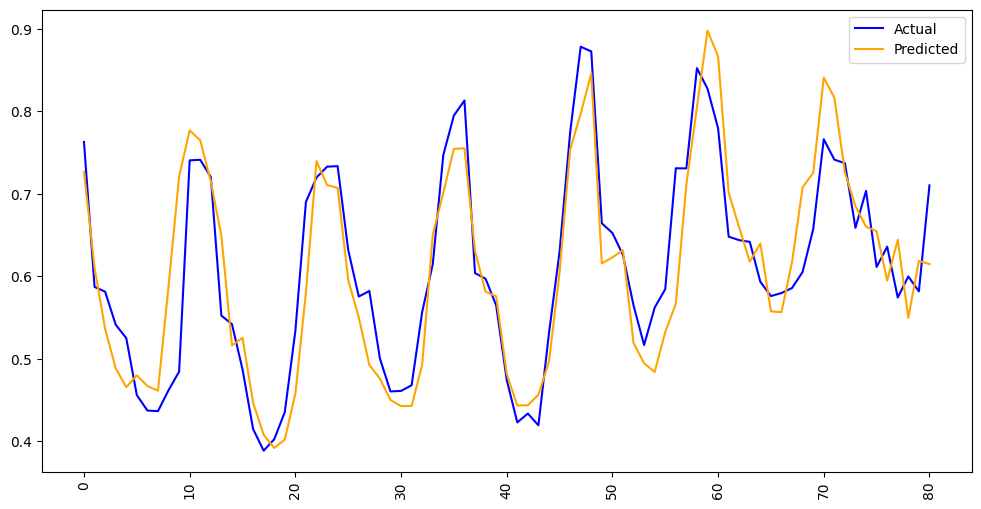

In [19]:
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual', color='blue')
plt.plot(y_predict, label='Predicted', color='orange')
plt.xticks(rotation="vertical")
plt.legend()
plt.show()

In [26]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# 1. Reshape X_train thành 3D cho LSTM: (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))  # (455,12,1)

# 2. Reshape y_train thành 2D (455, 1) cho chắc chắn
y_train = y_train.reshape(-1, 1)

model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(12, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, batch_size=16, epochs=200)

Epoch 1/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0984
Epoch 2/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0284
Epoch 3/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0296
Epoch 4/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0275
Epoch 5/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0214
Epoch 6/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0194
Epoch 7/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0129
Epoch 8/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0089
Epoch 9/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0070
Epoch 10/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0064
Epoch 11/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0060
Epoch 12/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0055
Epoch 13/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0057
Epoch 14/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0058
Epoch 15/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0063
Epoc

In [21]:
y_predict = model.predict(X_test)

y_predict_actual = scaler.inverse_transform(y_predict.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

mse_actual = mean_squared_error(y_test_actual, y_predict_actual)
mae_actual = mean_absolute_error(y_test_actual, y_predict_actual)
print("LSTM Actual Mean Squared Error:", mse_actual)
print("LSTM Actual Mean Absolute Error:", mae_actual)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 382ms/step
LSTM Actual Mean Squared Error: 19.780091295794584
LSTM Actual Mean Absolute Error: 3.628151532811296


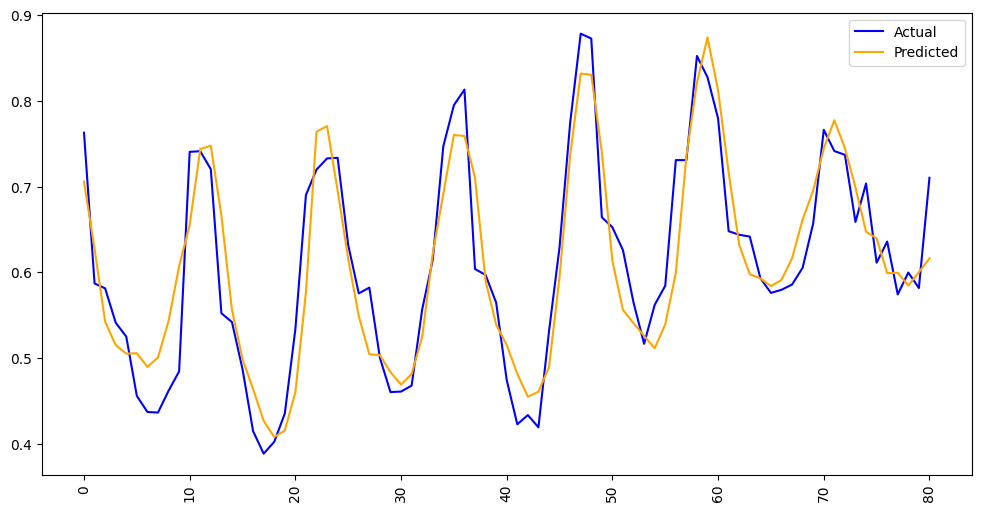

In [22]:
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual', color='blue')
plt.plot(y_predict, label='Predicted', color='orange')
plt.xticks(rotation="vertical")
plt.legend()
plt.show()

In [24]:
print(X_train.shape)  # phải ra (số mẫu, 12, 1)
print(y_train.shape)  # phải ra (số mẫu, 1) hoặc (số mẫu,)


(455, 12)
(455,)


In [ ]:
test_points = [x.item() for x in y_test[-12:,0]]

print("Test Points:", test_points)
for i in range(12):
    test_seq = np.array(test_points[-12:], dtype=np.float32).reshape(1, 12, 1)

    print(f"Step {i+1}: Input shape to model: {test_seq.shape}, dtype: {test_seq.dtype}")

    next_pred = model.predict(test_seq, verbose=0)

    print(f"Step {i+1}: Prediction raw output: {next_pred}, type: {type(next_pred)}")

    pred_value = next_pred[0][0]
    test_points.append(float(pred_value))
print("Next 12 Predictions:", test_points[-12:])

Test Points: [0.6571716058014665, 0.7662079366786785, 0.7414775273848582, 0.7371120851933524, 0.6588243335305402, 0.7036384660893884, 0.6112918840423816, 0.6359909195216837, 0.5742752648846341, 0.5998370802631816, 0.5817287868194123, 0.7103076426612167]
Step 1: Input shape to model: (1, 12, 1), dtype: float32
Step 1: Prediction raw output: [[0.68554217]], type: <class 'numpy.ndarray'>
Step 2: Input shape to model: (1, 12, 1), dtype: float32
Step 2: Prediction raw output: [[0.71961653]], type: <class 'numpy.ndarray'>
Step 3: Input shape to model: (1, 12, 1), dtype: float32
Step 3: Prediction raw output: [[0.71791637]], type: <class 'numpy.ndarray'>
Step 4: Input shape to model: (1, 12, 1), dtype: float32
Step 4: Prediction raw output: [[0.69700783]], type: <class 'numpy.ndarray'>
Step 5: Input shape to model: (1, 12, 1), dtype: float32
Step 5: Prediction raw output: [[0.65909094]], type: <class 'numpy.ndarray'>
Step 6: Input shape to model: (1, 12, 1), dtype: float32
Step 6: Prediction 

In [28]:
y_test_predicted = test_points[-12:]
y_test_predicted = scaler.inverse_transform(np.array(y_test_predicted).reshape(-1,1))
print("Predicted values in next 12 months:", y_test_predicted)

Predicted values in next 12 months: [[111.85107038]
 [114.89208489]
 [114.74035147]
 [112.87434004]
 [109.49039333]
 [106.64035951]
 [103.46964495]
 [101.87822611]
 [100.8887406 ]
 [101.48368943]
 [103.12010593]
 [106.53358119]]
